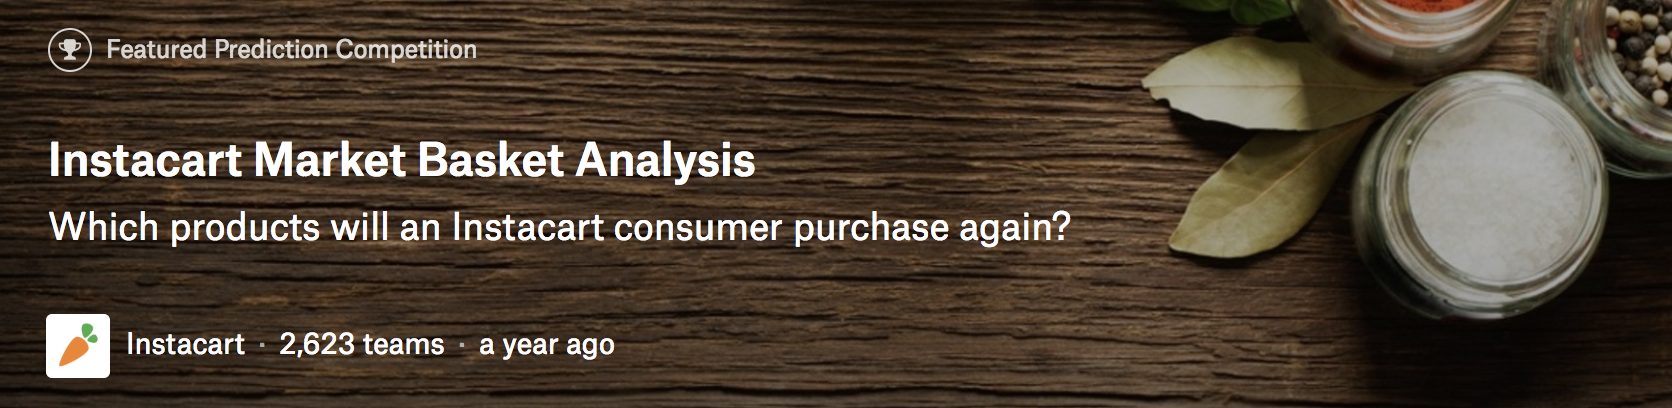

### The Task
The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

via Kaggle (https://www.kaggle.com/c/instacart-market-basket-analysis)

The task is to predict which products a user will reorder in their next order. The evaluation metric is the F1-score between the set of predicted products and the set of true products.

### Link Between Files
Image courtesy: Jordan Tremoureux via Kaggle (https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33128)

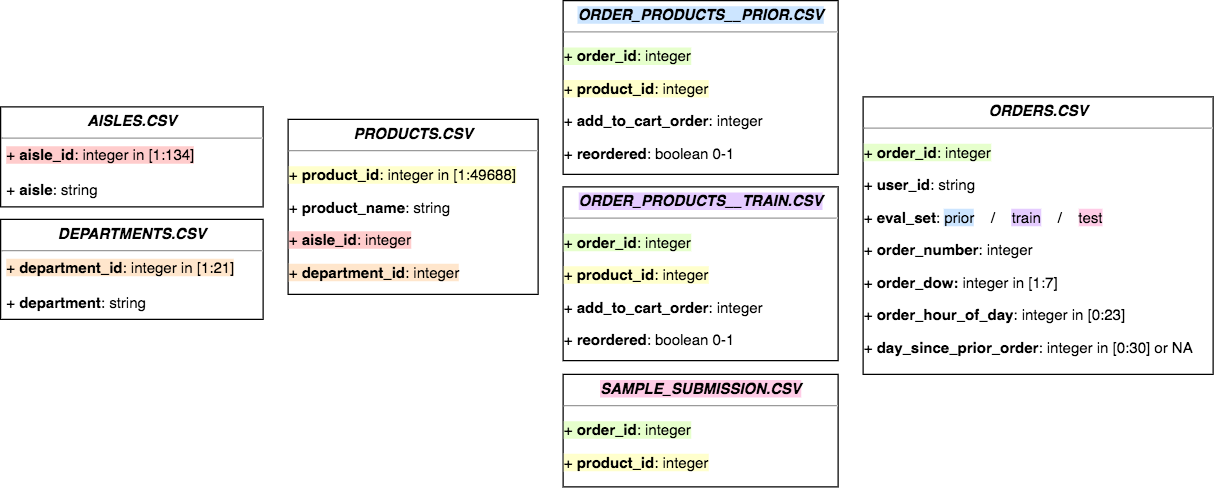

----------------

### Problem Statement

Estimate chance for each product to be in a cart in order to be able to give personalized offers.

#### Work Pipeline:

**1. Data Analysis & Preprocessing:**
* [A. Diagnostics](#diagnostics)
* [B. Order Analysis](#order)
* Product Analysis

**2. Feature Engineering:** 
* Feature Engineer till you drop approach
* *Stretch Goal: Deep Learning Feature Selection using RNN*  

**3. Model Selection:**
* Classification with Bayesian Network
* Classification with Ensemble Methods

**Bonus**
* User Recommender System using TensorFlow

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib;
import matplotlib.pyplot as plt;

import seaborn as sns; sns.set()

matplotlib.rcParams['font.family'] = 'monospace';
matplotlib.rcParams['font.weight'] = 3;
matplotlib.rcParams['font.size'] = 10;

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Data Analysis & Preprocessing

<a id='diagnostics'></a>
### A . Diagnostics

In [3]:
#Read Files
aisles = pd.read_csv('./all/aisles.csv')
dept = pd.read_csv('./all/departments.csv')
prod = pd.read_csv('./all/products.csv')
train = pd.read_csv('./all/order_products__prior.csv')
test = pd.read_csv('./all/order_products__train.csv')
orders = pd.read_csv('./all/orders.csv')

In [4]:
ls_files = [aisles, dept, prod, train, test, orders]
file_names = ['aisles', 'dept', 'prod', 'train', 'test', 'orders']

In [5]:
for i in range (6):
    shape = ls_files[i].shape
    filename = file_names[i]
    print('shape of "{}": '.format(filename), shape)

shape of "aisles":  (134, 2)
shape of "dept":  (21, 2)
shape of "prod":  (49688, 4)
shape of "train":  (32434489, 4)
shape of "test":  (1384617, 4)
shape of "orders":  (3421083, 7)


In [6]:
#Look at columns contained in the files

for i in range (6):
    col = ls_files[i].columns.values
    filename = file_names[i]
    print('columns in "{}": '.format(filename), col)

columns in "aisles":  ['aisle_id' 'aisle']
columns in "dept":  ['department_id' 'department']
columns in "prod":  ['product_id' 'product_name' 'aisle_id' 'department_id']
columns in "train":  ['order_id' 'product_id' 'add_to_cart_order' 'reordered']
columns in "test":  ['order_id' 'product_id' 'add_to_cart_order' 'reordered']
columns in "orders":  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [7]:
#Look at columns in the files with null values
for i in range (6):
    nulls = ls_files[i].isnull().sum()[ls_files[i].isnull().sum() > 0]
    filename = file_names[i]
    if nulls.empty:
        print('no column in "{}" contained null values. '.format(filename))
    else: 
        print('columns contained null values in "{}" is '.format(filename), nulls)

no column in "aisles" contained null values. 
no column in "dept" contained null values. 
no column in "prod" contained null values. 
no column in "train" contained null values. 
no column in "test" contained null values. 
columns contained null values in "orders" is  days_since_prior_order    206209
dtype: int64


Only `orders` file contained null values, specifically `days_since_prior_order` column - which is understandable as the first order has no precedent and not every customer will return. So I'll leave this as it is. 

<a id='order'></a>

### B. Order Analysis

In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


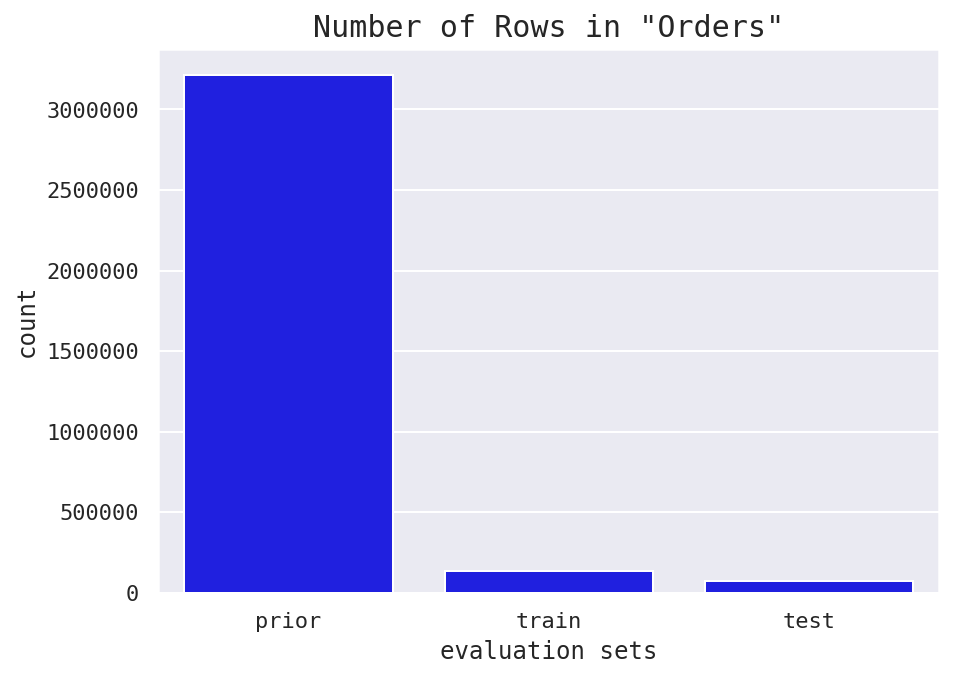

In [10]:
plt.figure(figsize=(7,5))
sns.barplot(orders.eval_set.unique(), orders.eval_set.value_counts(), color='blue')
plt.title('Number of Rows in "Orders"', size =15)
plt.xlabel('evaluation sets')
plt.ylabel('count')
plt.show()

In [13]:
#First let's subset the order file by evaluation set
order_prior = orders.loc[orders['eval_set'] == 'prior']
order_train = orders.loc[orders['eval_set'] == 'train']
order_test = orders.loc[orders['eval_set'] == 'test']

In [14]:
#Let's find out the unique customers

order_prior_uniqueuser = len(np.unique(order_prior.user_id))
order_train_uniqueuser = len(np.unique(order_train.user_id))
order_test_uniqueuser = len(np.unique(order_test.user_id))
print('Unique Users in Prior Set:', order_prior_uniqueuser, '   ',  
      'Unique Users in Train Set:', order_train_uniqueuser, '   ',
      'Unique Users in Test Set:', order_test_uniqueuser)

Unique Users in Prior Set: 206209     Unique Users in Train Set: 131209     Unique Users in Test Set: 75000


**There are over 3,4 million order data in `prior` dataset contributed by 206,209 customers (total). Out of the total, the order of 131,209 customers are unique and was given as `train` set. Our task is to predict for the rest of the 75,000 customer and their unique order in the `test` set.**

#### Order Distribution

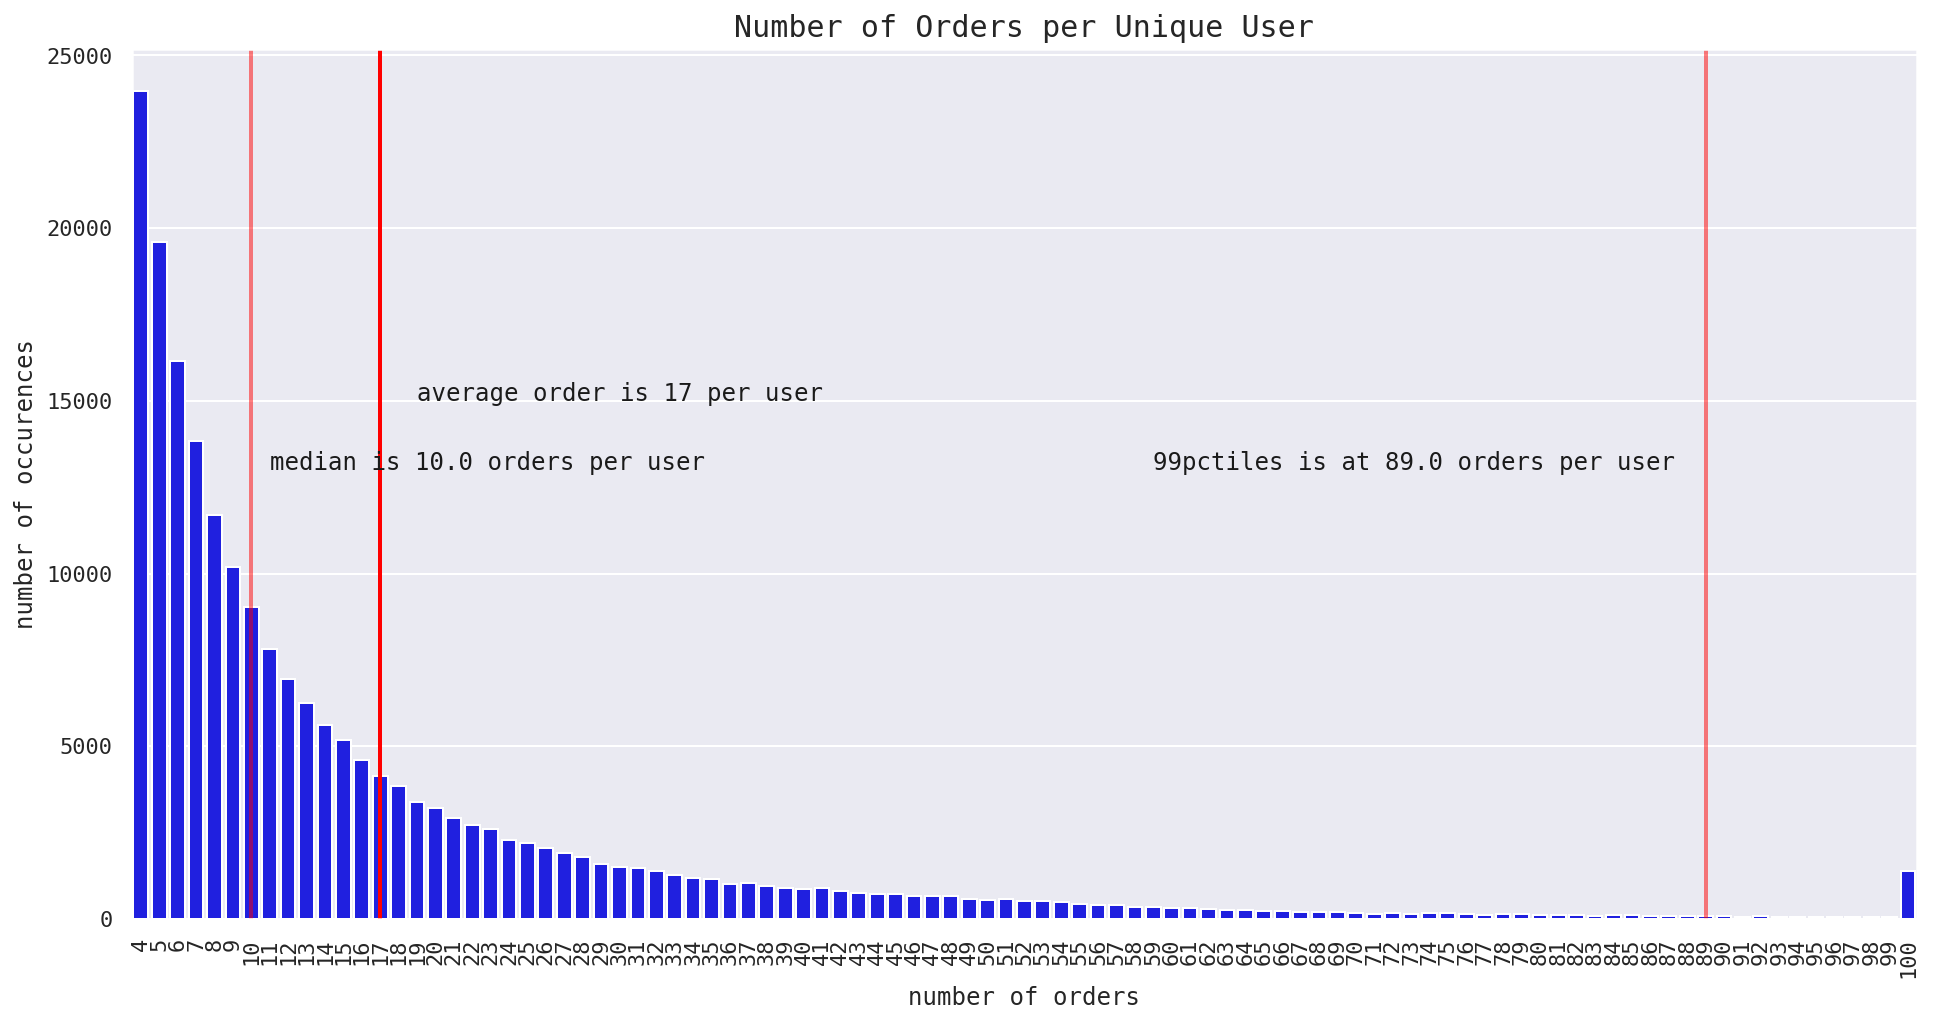

In [15]:
#Look at the distribution of the orders per user ID
user_max_order = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
max_order_count = user_max_order.order_number.value_counts()

#Plot the distribution
_ = plt.figure(figsize=(16,8))
_ = sns.barplot(max_order_count.index, max_order_count.values, color='blue')
_ = plt.title('Number of Orders per Unique User', fontsize=15)
_ = plt.ylabel('number of occurences', fontsize=12)
_ = plt.xlabel('number of orders', fontsize=12)
_ = plt.xticks(rotation='vertical')

#Plot the vertical lines
_ = plt.axvline(13, linestyle='-', color='red', linewidth=2)
_ = plt.axvline(6, linestyle='-', color='red', alpha=0.5, linewidth=2)
_ = plt.axvline(85, linestyle='-', color='red', alpha=0.5, linewidth=2)
_ = plt.text(15, 15000, 'average order is {} per user'.format(round(np.mean(user_max_order.order_number))), color = 'k', fontsize=12)
_ = plt.text(7, 13000, 'median is {} orders per user'.format(np.percentile(user_max_order.order_number, 50)), color = 'k', fontsize=12)
_ = plt.text(55, 13000, '99pctiles is at {} orders per user'.format(np.percentile(user_max_order.order_number, 99)), color = 'k', fontsize=12)

plt.show()

The maximum number of orders per user id is 99. This is an exponential distribution, intuitively this make sense.

Insights: 
* The average number of order is 17 per user
* 1% of the customer order more than 89 times (party!!!)
* 50% of the customer order less than 10 times
* Assuming everything is equal this means the customer purchasing behaviour, as measured by number of repeat purchase, is sub-optimal. Thus perhaps marketing can boost their promotional efforts towards a subset of customers who order less than 16 times but more than 9 times, in a hope to close the gap. 

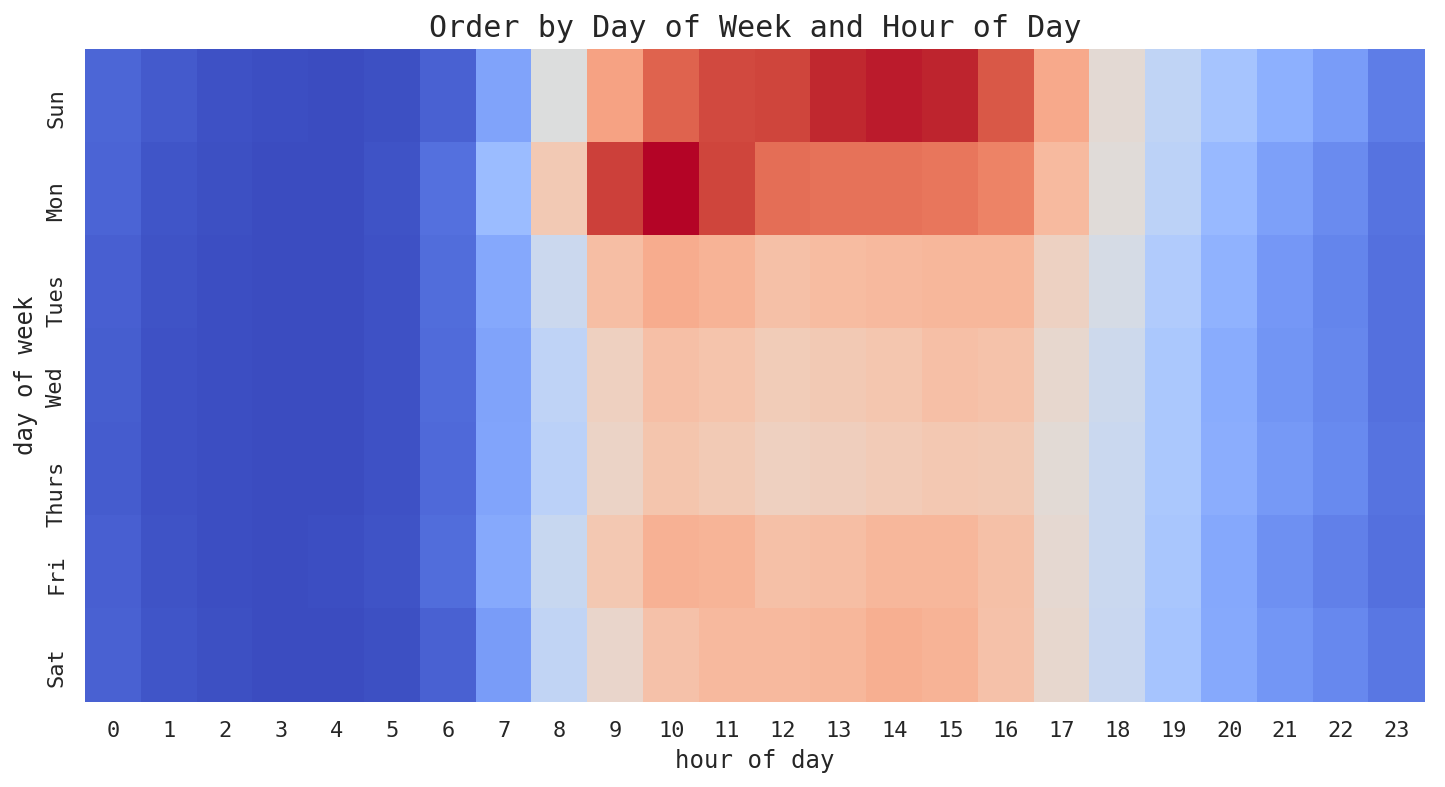

In [16]:
#Look at order distribution by Day of Week and Hour of Day

heatmap_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].count().reset_index()
heatmap_df = heatmap_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

yticks ='Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'

_ = plt.figure(figsize=(12,6))
_ = sns.heatmap(heatmap_df, cmap="coolwarm", cbar=False, yticklabels=yticks)
_ = plt.title("Order by Day of Week and Hour of Day", fontsize = 15)
_ = plt.ylabel("day of week", fontsize = 12)
_ = plt.xlabel("hour of day", fontsize = 12)

Insights: 
* In general, orders are placed everyday mostly between 10AM - 4PM
* Sunday and Monday are the busiest day for order placement. 
* The hottest timing for order placement is Sunday between 1 - 3PM and Monday between 9 - 11AM. 
* Wednesday and Thursday are less busy for order placement.

#### Order Frequency

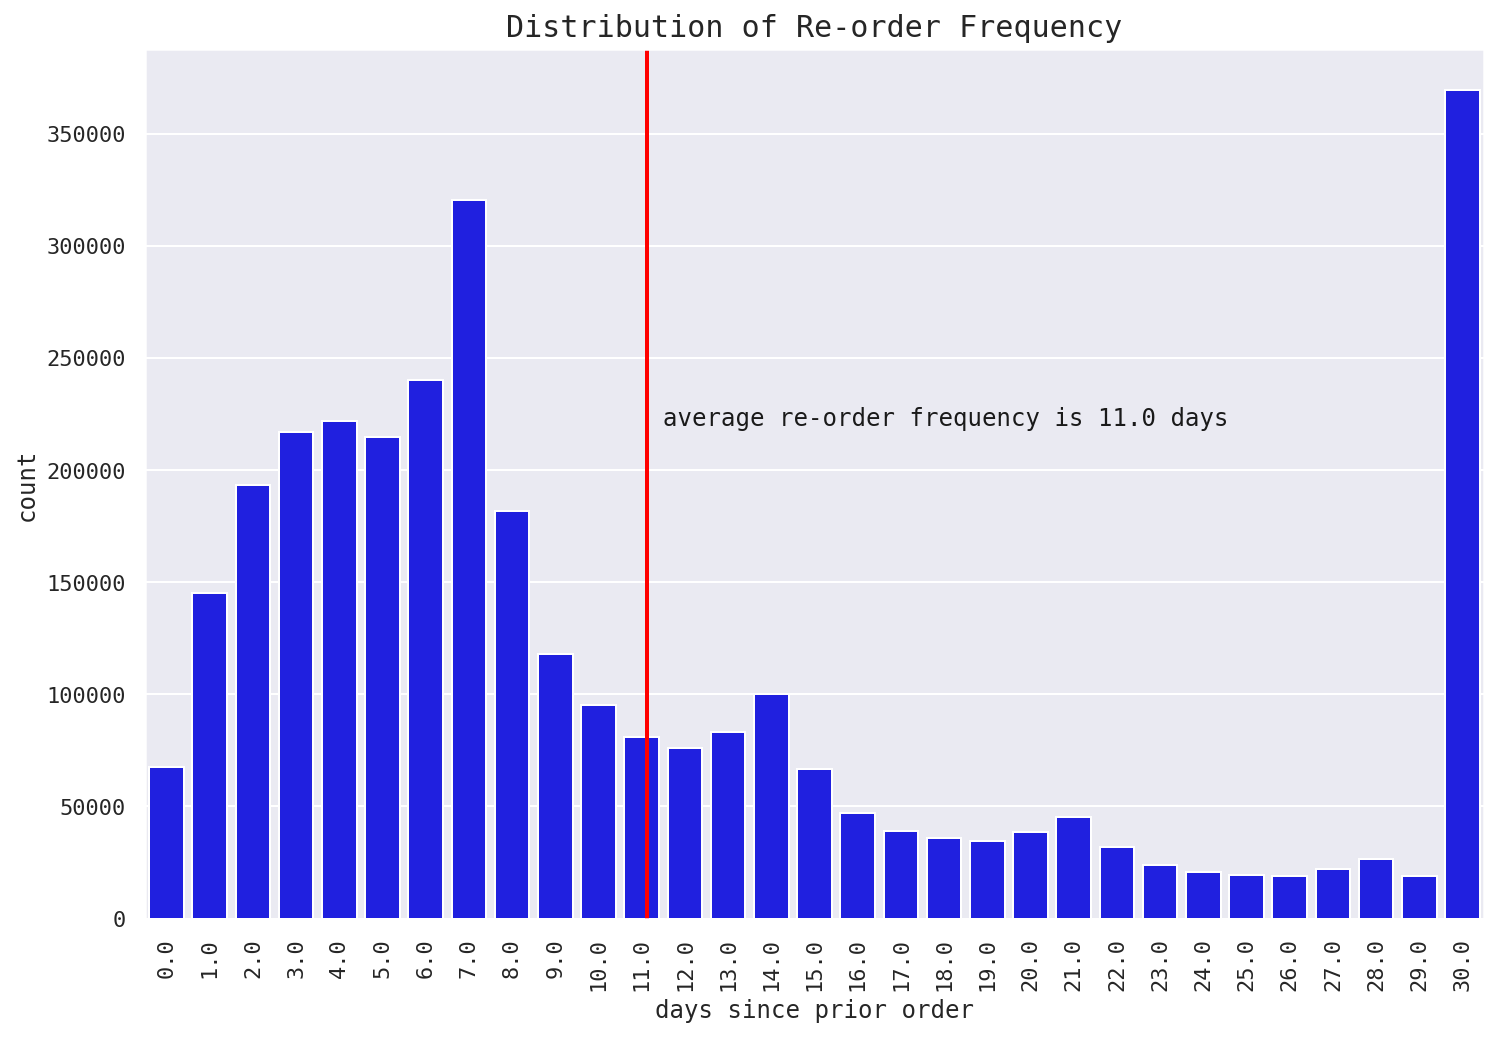

In [17]:
#Look at the distribution of lag-time between orders

order_by_prior_order = orders.groupby('days_since_prior_order')['order_id'].count().reset_index()
order_by_prior_order['cumsum_days'] = order_by_prior_order.days_since_prior_order * order_by_prior_order.order_id
avg_days_per_count = order_by_prior_order.cumsum_days.sum()/order_by_prior_order.order_id.sum()

_ = plt.figure(figsize=(12,8))
_ = sns.barplot(order_by_prior_order.days_since_prior_order, order_by_prior_order.order_id, color='blue')
_ = plt.title('Distribution of Re-order Frequency', fontsize=15)
_ = plt.ylabel('count', fontsize=12)
_ = plt.xlabel('days since prior order', fontsize=12)
_ = plt.xticks(rotation='vertical')

#plot line

_ = plt.axvline(avg_days_per_count, linestyle='-', color='red', linewidth=2)
_ = plt.text(11.5, 220000, 'average re-order frequency is {} days'.format(round(avg_days_per_count)), color = 'k', fontsize=12)

#### Ordered vs Reordered

In [48]:
#Merge products related files into one dataframe
product_order_merged = pd.merge(pd.merge(pd.merge(pd.merge(prod, train, on="product_id", how="left"), \
                                                aisles, on="aisle_id", how="left"), \
                                       dept, on="department_id", how="left"), orders, on="order_id", how="left")

In [19]:
#find percentage of ordered and reordered
product_order_count = product_order_merged.groupby('department').product_id.count()
percentage_ordered = [i/sum(product_order_count) for i in product_order_count]

product_reorder_count = product_order_merged.groupby('department').reordered.sum()
percentage_reordered = [i/sum(product_reorder_count) for i in product_reorder_count]

#convert to dataframe
product_order_df = pd.DataFrame(product_order_count).reset_index()
product_order_df['percentage_ordered'] = percentage_ordered
product_order_df['percentage_reordered'] = percentage_reordered
product_order_df.columns = ['department', 'order_count', 'percentage_ordered', 'percentage_reordered']

In [20]:
#percentage 
product_order_df

,department,order_count,percentage_ordered,percentage_reordered
0,alcohol,153696,0.004739,0.004580
1,babies,423802,0.013066,0.012829
2,bakery,1176787,0.036282,0.038647
3,beverages,2690131,0.082940,0.091909
4,breakfast,709570,0.021877,0.020809
5,bulk,34573,0.001066,0.001043
6,canned goods,1068058,0.032930,0.025542
7,dairy eggs,5414017,0.166922,0.189643
8,deli,1051249,0.032411,0.033402
9,dry goods pasta,866627,0.026719,0.020891


In [22]:
#Melt to plot
product_order_df2 = product_order_df.drop('order_count', axis=1)
product_order_df2 = pd.melt(product_order_df2, id_vars="department", var_name="order/reordered", value_name="percentage")

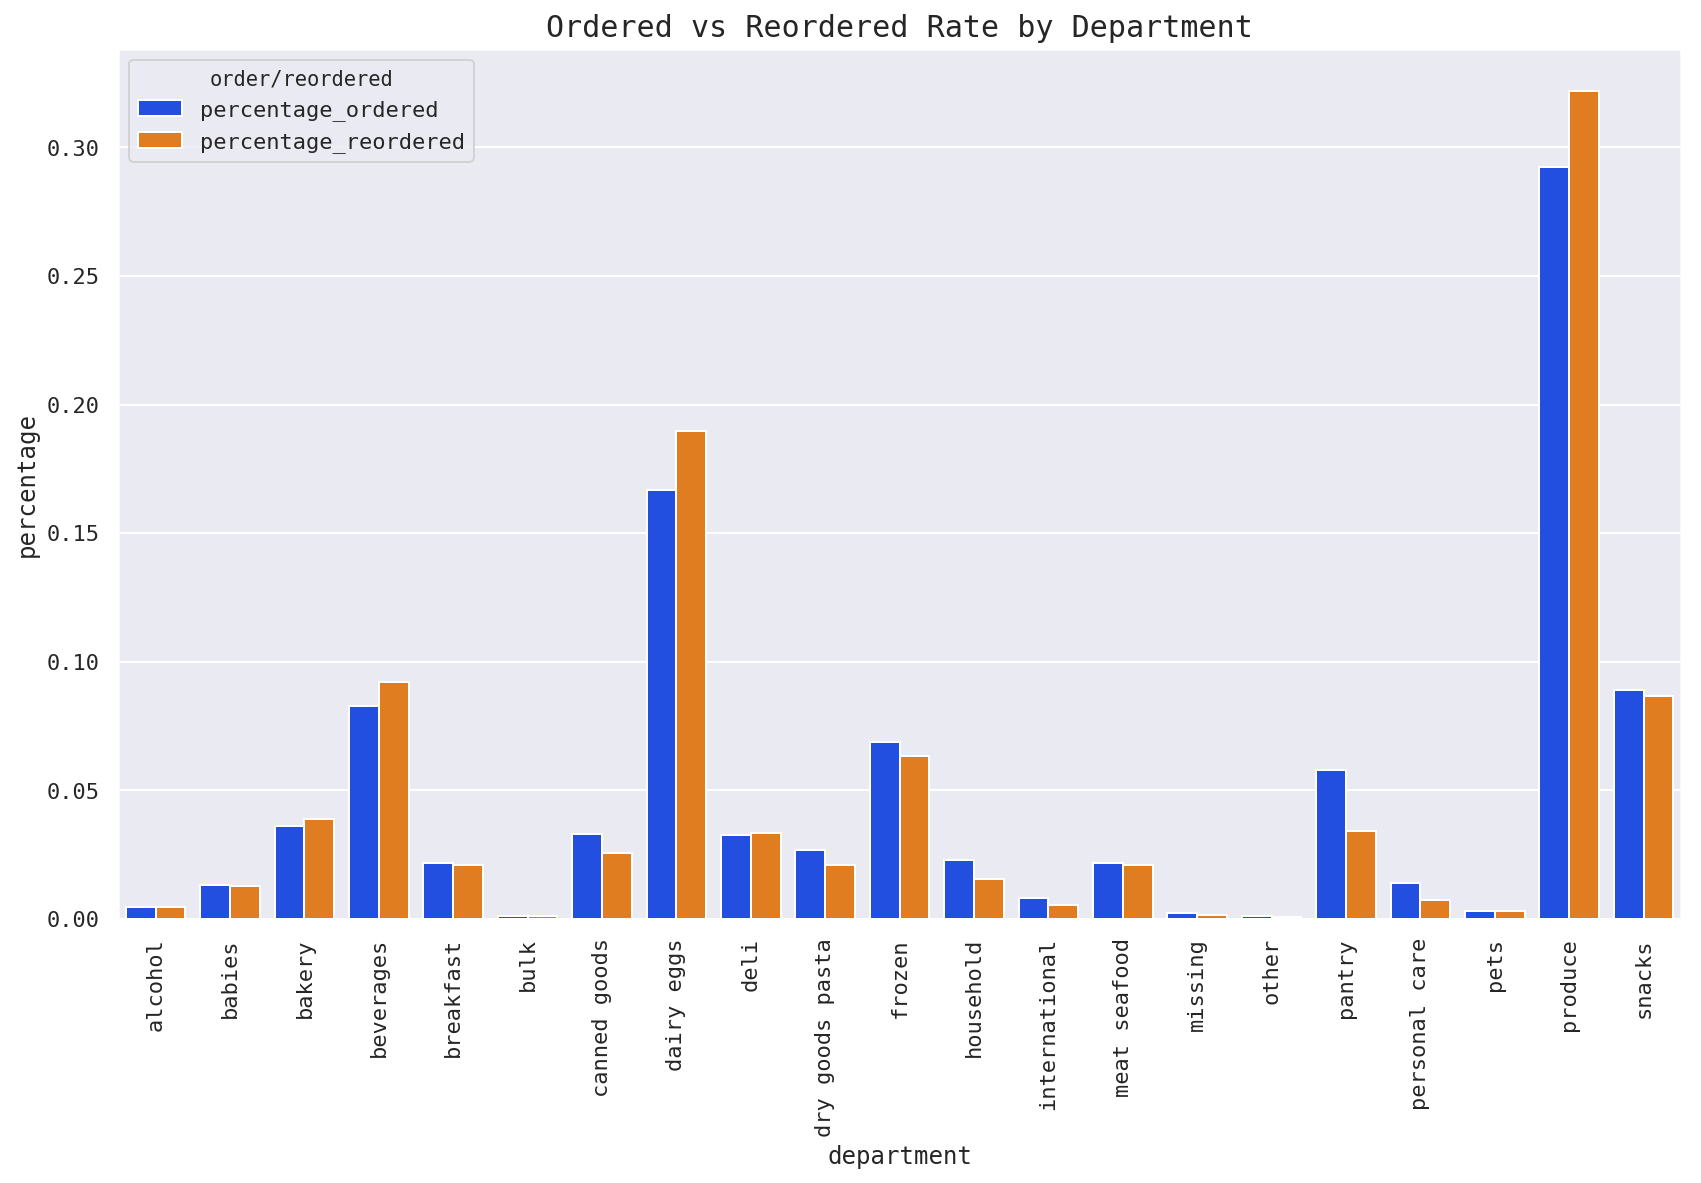

In [23]:
#Plot it
_ = plt.figure(figsize=(14,8))
_ = sns.barplot(x='department', y='percentage', hue='order/reordered', data=product_order_df2, palette='bright')
_ = plt.title('Ordered vs Reordered Rate by Department', fontsize=15)
_ = plt.ylabel('percentage', fontsize=12)
_ = plt.xlabel('department', fontsize=12)
_ = plt.xticks(rotation=90)

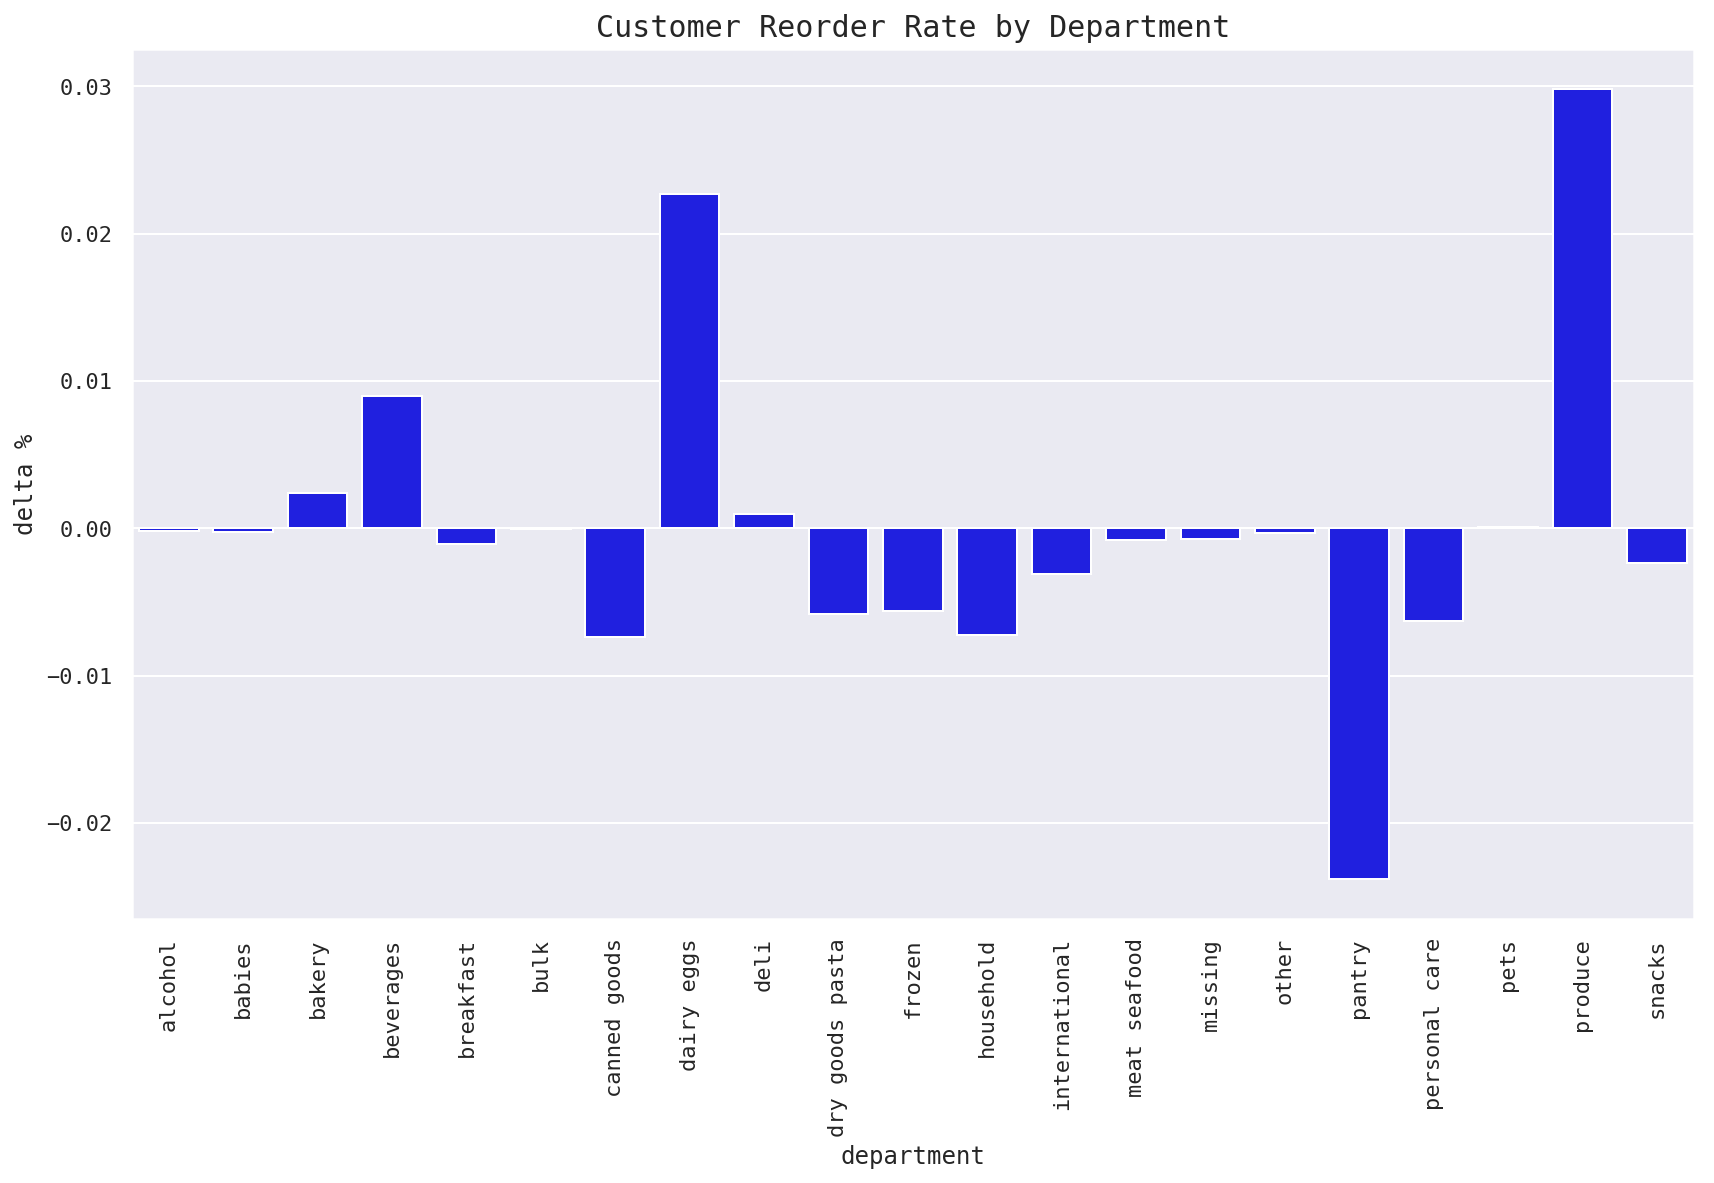

In [24]:
#Changes are hard to see in the graph above so let's zoom in a little bit
product_order_df['delta'] = product_order_df.percentage_reordered - product_order_df.percentage_ordered

_ = plt.figure(figsize=(14,8))
_ = sns.barplot(x='department', y='delta', data=product_order_df, color='blue')
_ = plt.title('Customer Reorder Rate by Department', fontsize=15)
_ = plt.ylabel('delta %', fontsize=12)
_ = plt.xlabel('department', fontsize=12)
_ = plt.xticks(rotation=90)

### C. Product Analysis

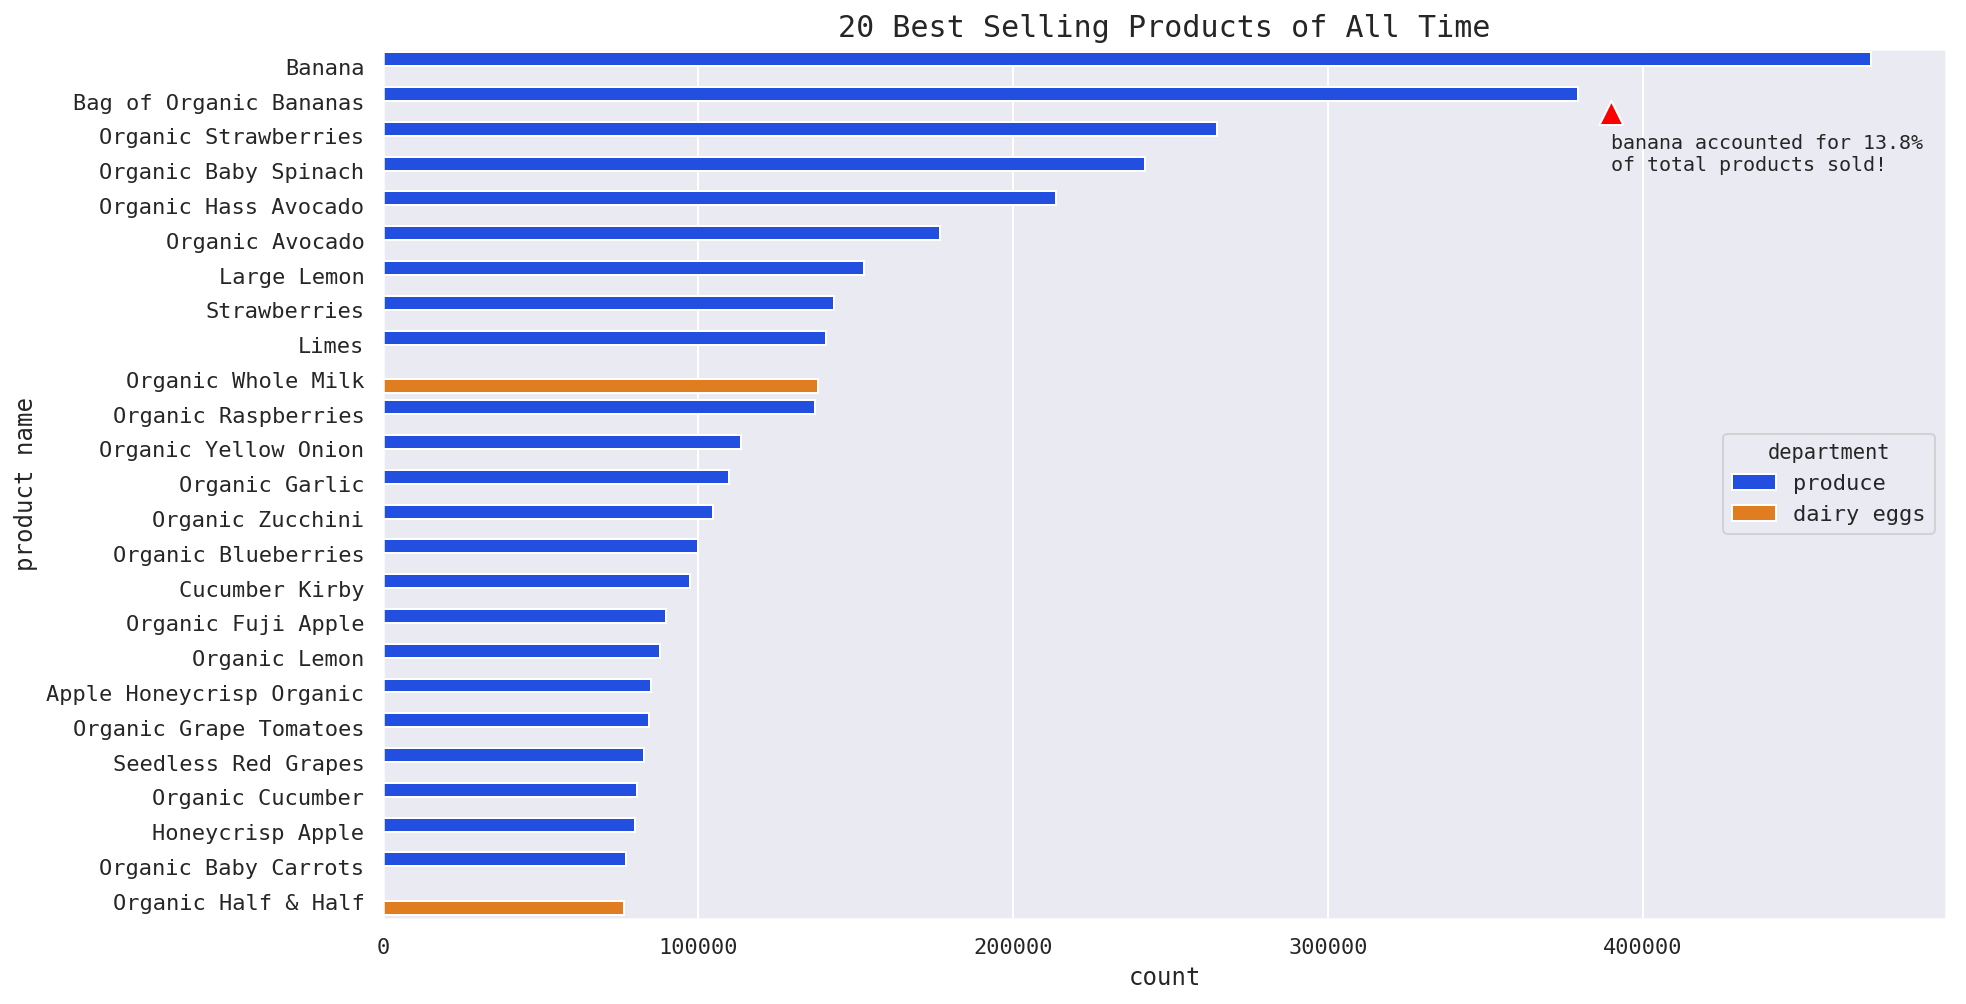

In [58]:
#Look at the most popular product

topseller = pd.DataFrame(product_order_merged.groupby(['department', 'product_name'])['order_number'].count().reset_index())
topseller_all_time = topseller.sort_values(by='order_number', ascending=False).head(25)

_ = plt.figure(figsize=(14,8))
_ = sns.barplot(topseller_all_time.order_number, topseller_all_time.product_name, hue=topseller_all_time.department, palette='bright')
_ = plt.title('20 Best Selling Products of All Time', fontsize=15)
_ = plt.ylabel('product name', fontsize=12)
_ = plt.xlabel('count', fontsize=12)

_ = plt.annotate('banana accounted for 13.8% \nof total products sold!', xy=(390000, 1), xytext=(390000, 3),
            arrowprops=dict(facecolor='red', shrink=.5) )

### Frequency of Purchase of Bestselling Products

In [26]:
topseller_freq = pd.DataFrame(product_order_merged.groupby(['department', 'product_name'])['days_since_prior_order','order_number']\
                              .aggregate({'days_since_prior_order': np.mean, 'order_number': sum}).reset_index())
topseller_freq_sort = pd.DataFrame(topseller_freq.sort_values(['order_number'],ascending=False)).head(20)

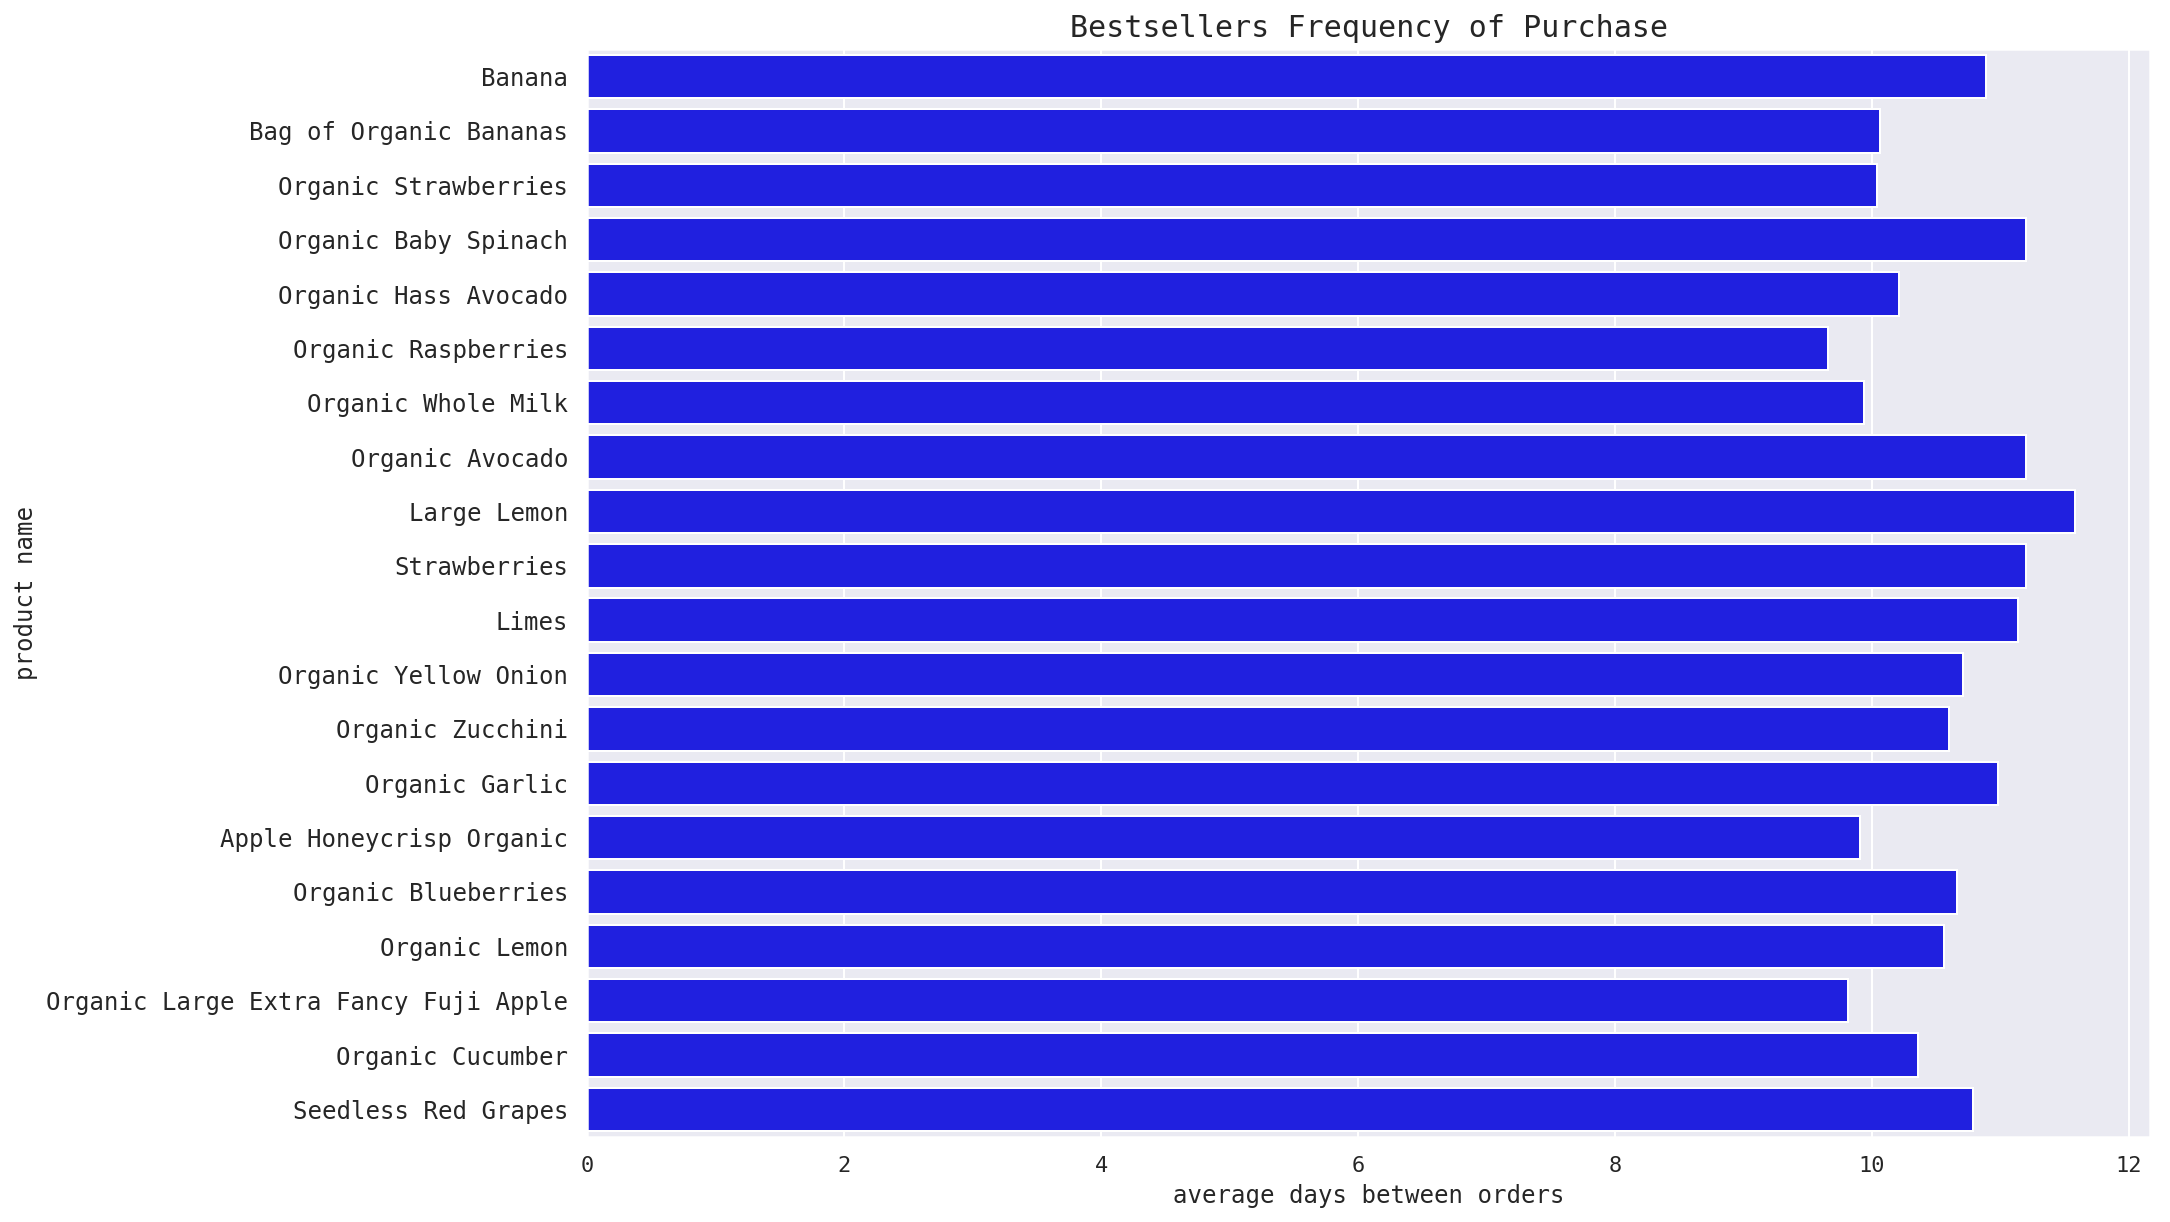

In [27]:
_ = plt.figure(figsize=(14,10))
_ = sns.barplot(topseller_freq_sort.days_since_prior_order, topseller_freq_sort.product_name, color='blue')
_ = plt.title('Bestsellers Frequency of Purchase', fontsize=15)
_ = plt.xlabel('average days between orders',fontsize=12)
_ = plt.ylabel('product name',fontsize=12)
_ = plt.yticks(fontsize=12)

#### The most popular product is BANANA!

A cursory glance of the products tell us that they belong to the `produce` categories, which is great but also common sense. There's also a large population of products belonging to the `organic` category. 

Let's try to dig more to find:
- Topselling product in every department
- Topselling product at certain times of day 
- Top Reordered item
- Organic vs Non-Organic
- Products often bought together given the hour and time

### Number of Products in basket

Most common order contains: 5.0 products


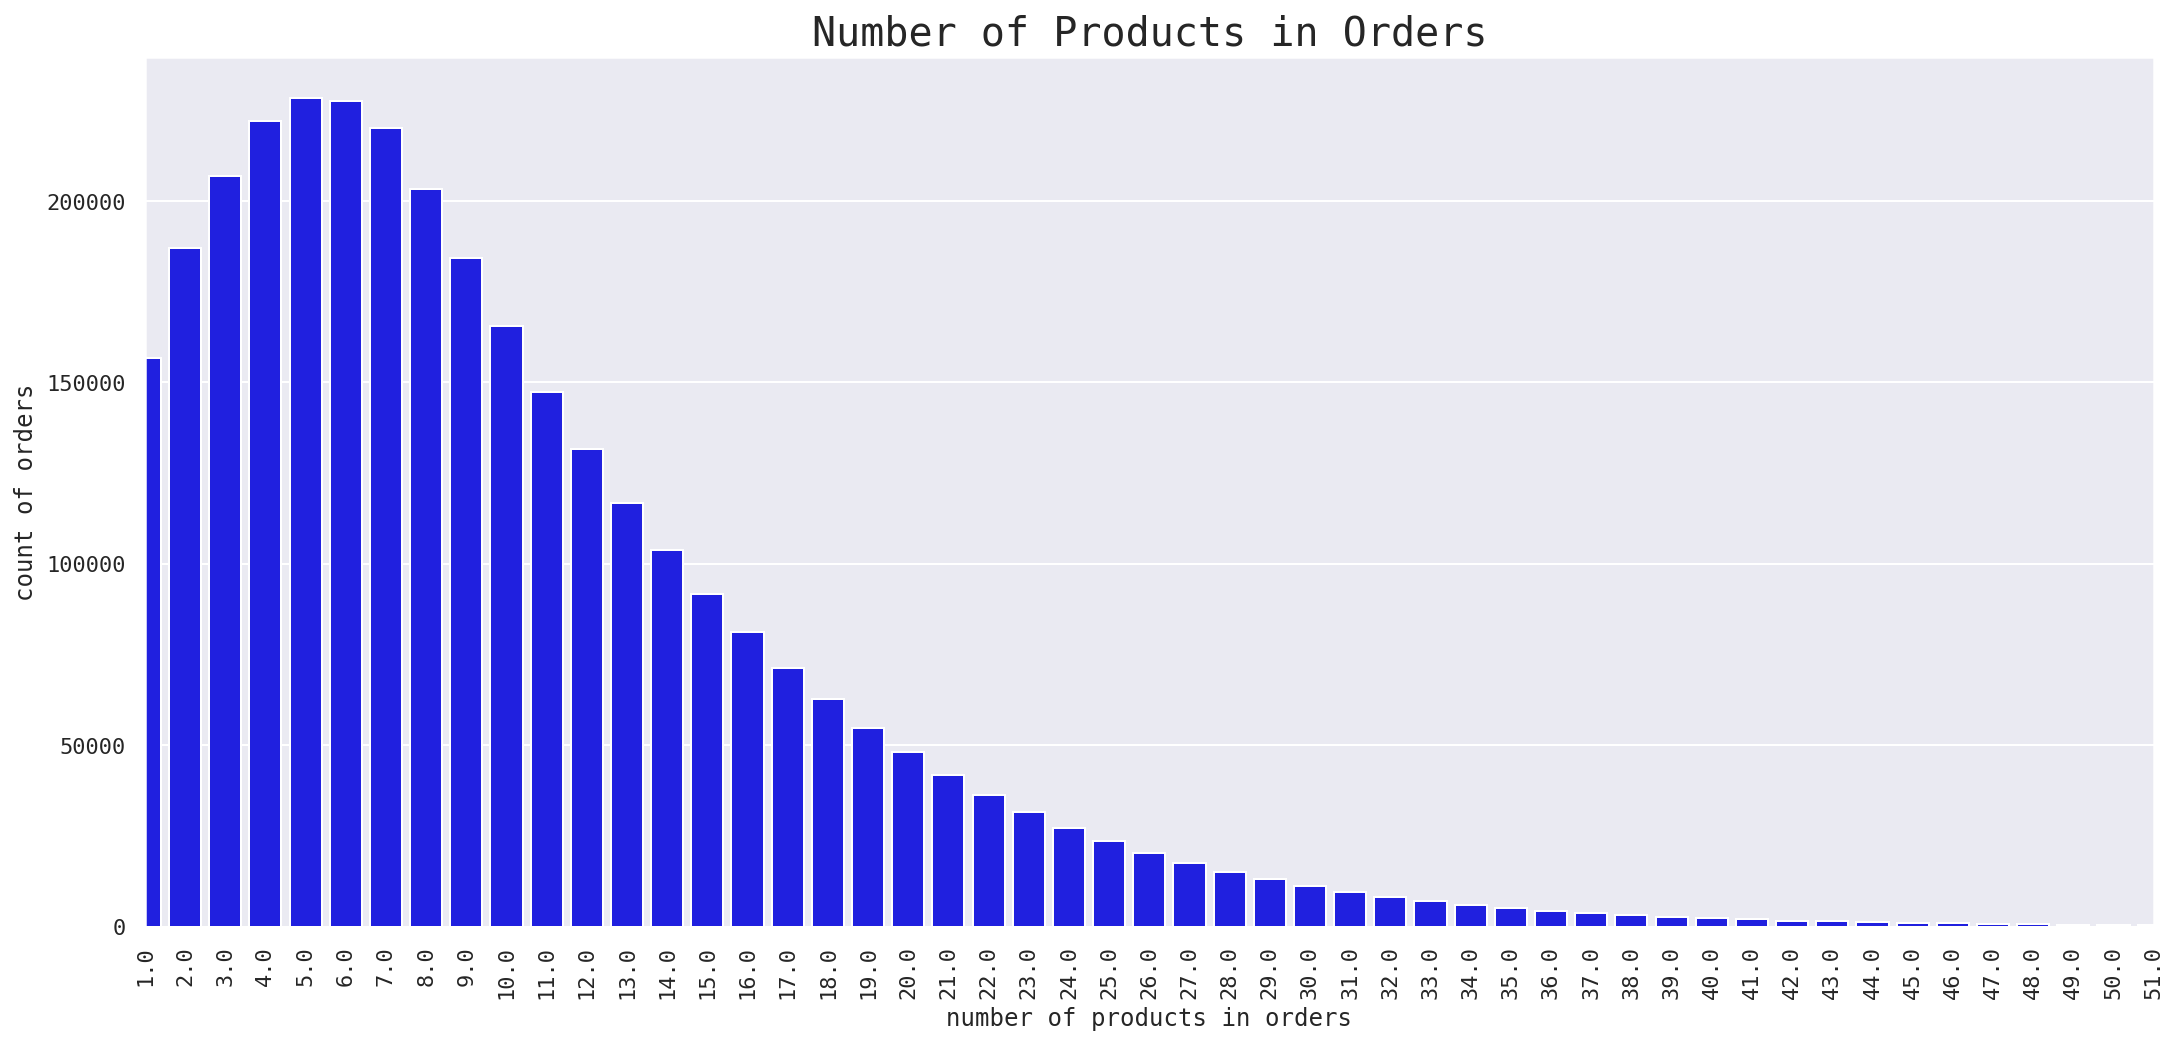

In [49]:
products_in_orders = product_order_merged.groupby("order_id")["add_to_cart_order"]\
.aggregate(np.max).reset_index()['add_to_cart_order'].value_counts()

print('Most common order contains: {} products'.format(
    products_in_orders[products_in_orders.values== products_in_orders.max()].index.values[0]))

# plot it
_ = plt.figure(figsize=(18, 8))
_ = sns.barplot(products_in_orders.index, products_in_orders.values, color='blue')
_ = plt.title('Number of Products in Orders', fontsize=20)
_ = plt.ylabel('count of orders', fontsize=12)
_ = plt.xlabel('number of products in orders', fontsize=12)
_ = plt.xticks(rotation='vertical')
_ = plt.xlim([0, 50])


In [40]:
np.sum(products_in_orders.values[0:8]/sum(products_in_orders.values))

0.522519078508209

#### Top Selling Product in  Every Department

In [50]:
#Most popular product in every department
topseller_by_dept = topseller.sort_values(by='order_number', ascending=False).groupby('department').head(1).reset_index()
topseller_by_dept = topseller_by_dept.drop('index', axis=1)
topseller_by_dept.columns = ['department', 'product_name', 'count_of_order']

In [51]:
topseller_by_dept

,department,product_name,count_of_order
0,produce,Banana,472565
1,dairy eggs,Organic Whole Milk,137905
2,beverages,Sparkling Water Grapefruit,75886
3,deli,Original Hummus,71314
4,bakery,100% Whole Wheat Bread,60816
5,frozen,Blueberries,55946
6,meat seafood,Boneless Skinless Chicken Breasts,50281
7,pantry,Extra Virgin Olive Oil,50255
8,canned goods,Organic Black Beans,38001
9,household,100% Recycled Paper Towels,27864


#### Most Frequently Purchased Product

In [52]:
min_number_of_times_bought = 100

order_by_product_id = product_order_merged.groupby(['product_id', 
                                                    'product_name'])[['days_since_prior_order', 
                                                                      'user_id']].aggregate({'days_since_prior_order': np.mean, 
                                                                                             'user_id': len}).reset_index()
frequent_products = pd.DataFrame(order_by_product_id[order_by_product_id.user_id > min_number_of_times_bought]\
                                 .sort_values(['days_since_prior_order'],ascending=True)).head(20)

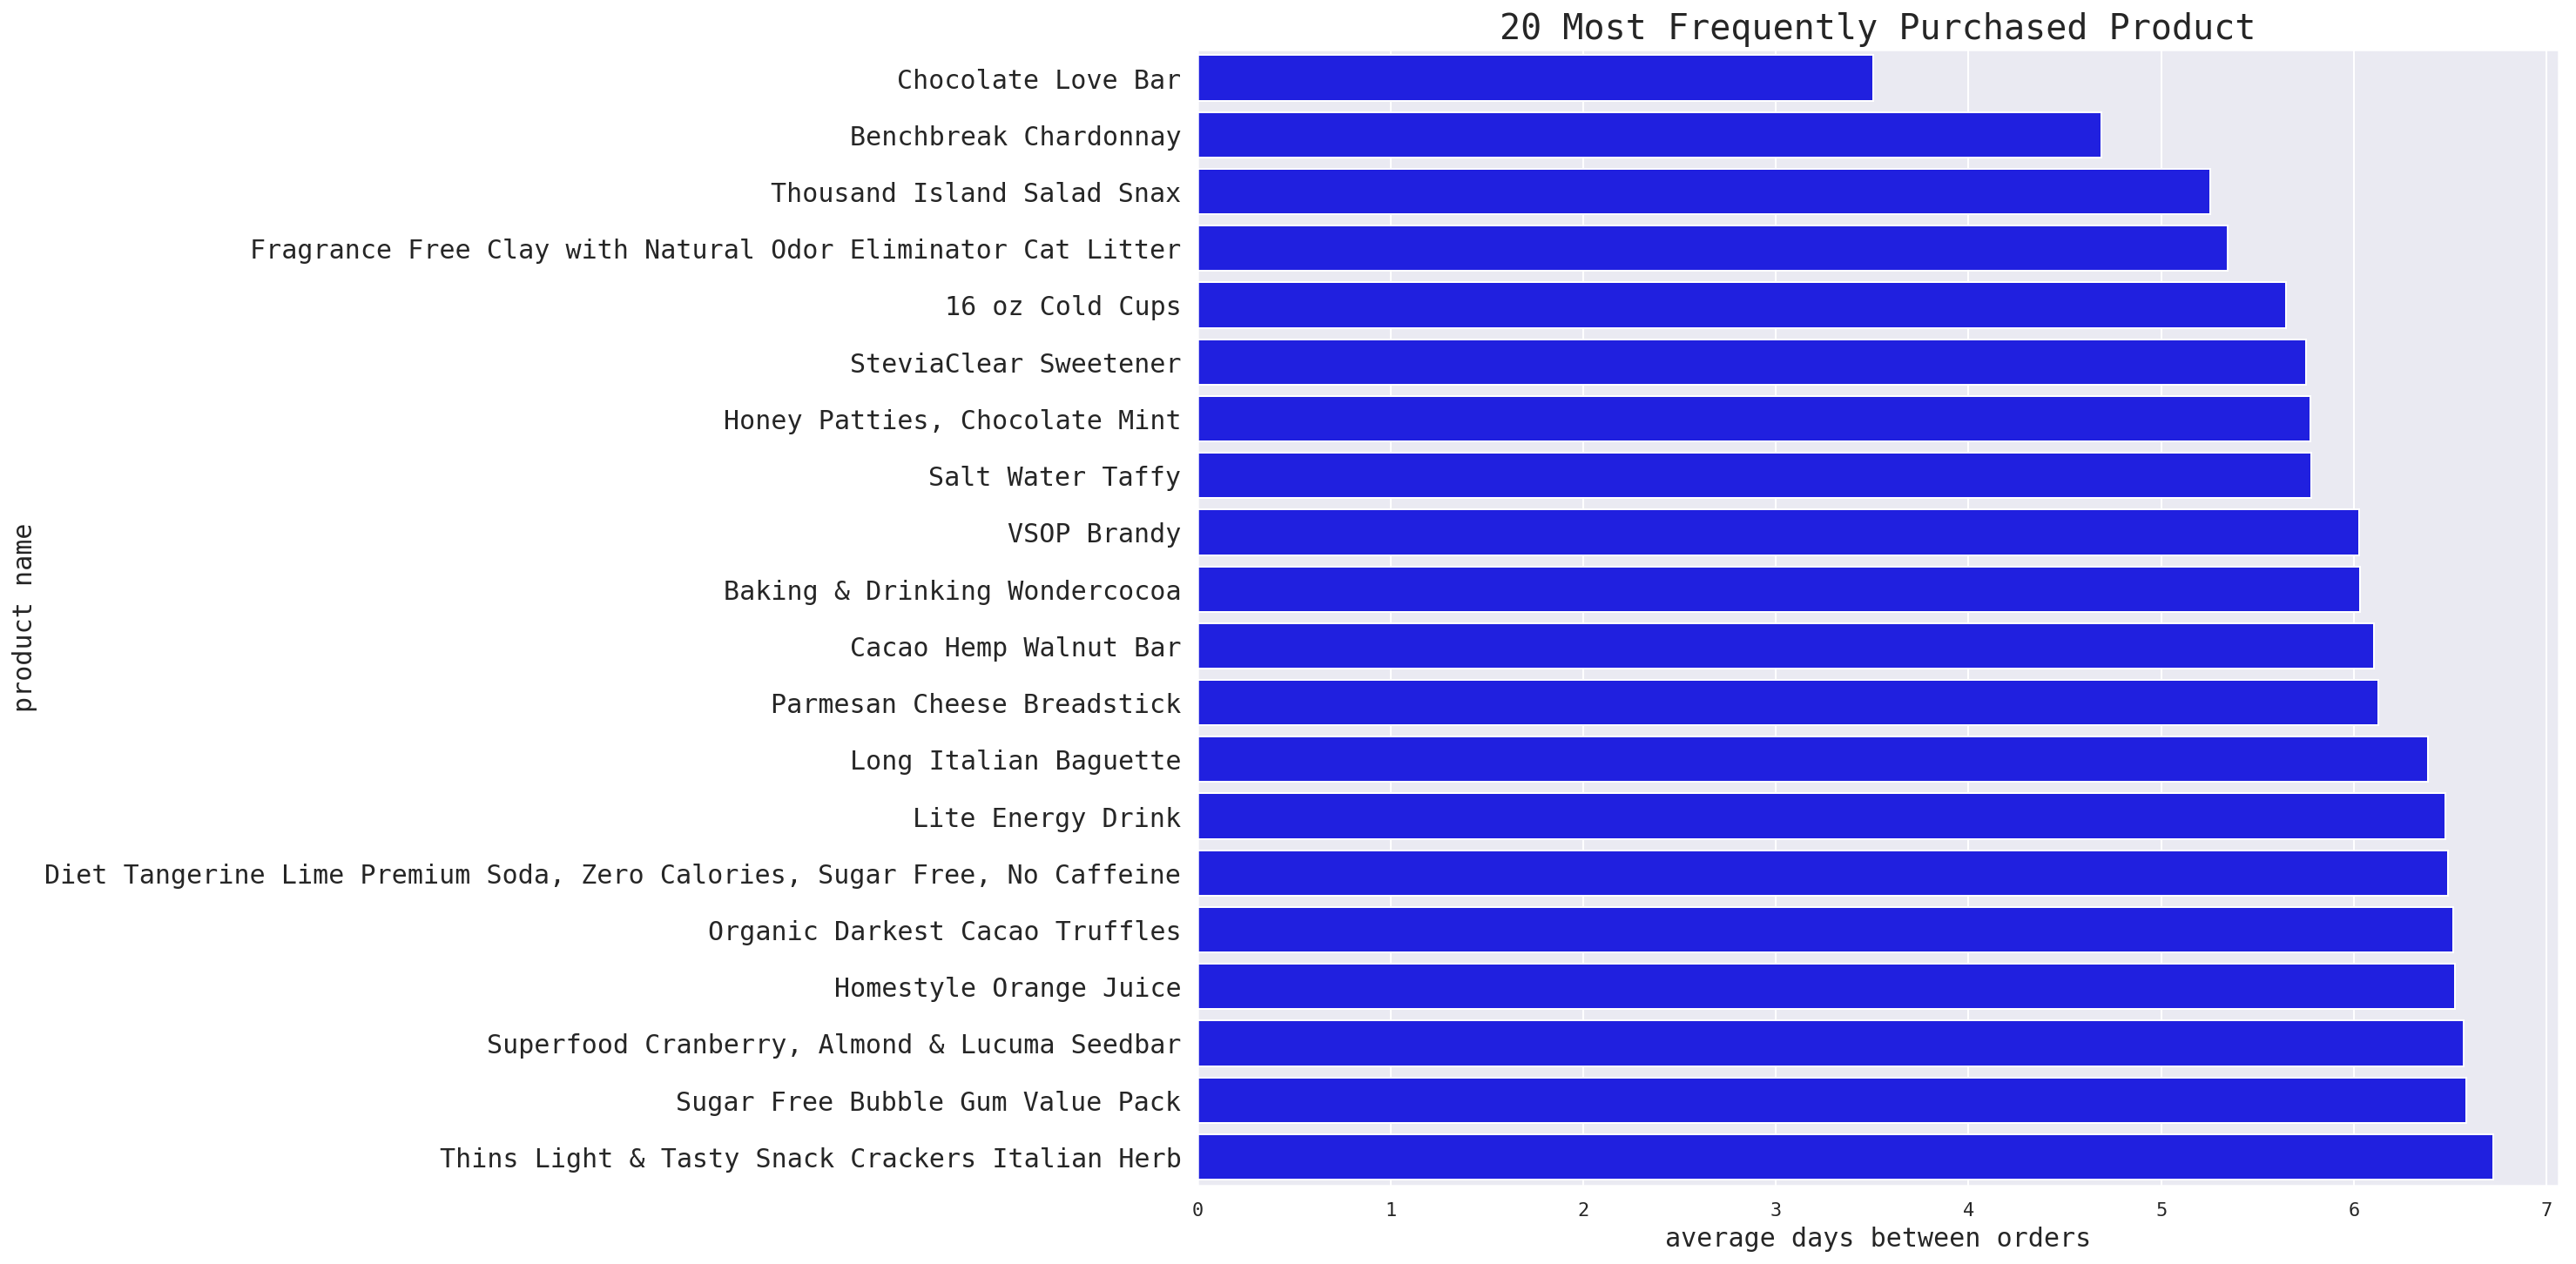

In [53]:
_ = plt.figure(figsize=(14,12))
_ = sns.barplot(frequent_products.days_since_prior_order, frequent_products.product_name, color='blue')
_ = plt.title('20 Most Frequently Purchased Product', fontsize=20)
_ = plt.xlabel('average days between orders',fontsize=15)
_ = plt.ylabel('product name',fontsize=15)
_ = plt.yticks(fontsize=15)

In [54]:
product_order_merged

,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,Chocolate Sandwich Cookies,61,19,1107.0,7.0,0.0,cookies cakes,snacks,38259.0,prior,2.0,1.0,11.0,7.0
1,1,Chocolate Sandwich Cookies,61,19,5319.0,3.0,1.0,cookies cakes,snacks,196224.0,prior,65.0,1.0,14.0,1.0
2,1,Chocolate Sandwich Cookies,61,19,7540.0,4.0,1.0,cookies cakes,snacks,138499.0,prior,8.0,0.0,14.0,7.0
3,1,Chocolate Sandwich Cookies,61,19,9228.0,2.0,0.0,cookies cakes,snacks,79603.0,prior,2.0,2.0,10.0,30.0
4,1,Chocolate Sandwich Cookies,61,19,9273.0,30.0,0.0,cookies cakes,snacks,50005.0,prior,1.0,1.0,15.0,NaN
5,1,Chocolate Sandwich Cookies,61,19,9696.0,5.0,1.0,cookies cakes,snacks,108919.0,prior,46.0,5.0,16.0,8.0
6,1,Chocolate Sandwich Cookies,61,19,11140.0,1.0,1.0,cookies cakes,snacks,63782.0,prior,4.0,1.0,14.0,14.0
7,1,Chocolate Sandwich Cookies,61,19,11485.0,4.0,0.0,cookies cakes,snacks,170451.0,prior,5.0,5.0,18.0,24.0
8,1,Chocolate Sandwich Cookies,61,19,12672.0,3.0,1.0,cookies cakes,snacks,106854.0,prior,28.0,5.0,10.0,6.0
9,1,Chocolate Sandwich Cookies,61,19,13668.0,4.0,1.0,cookies cakes,snacks,181127.0,prior,10.0,4.0,17.0,9.0


In [55]:
order_by_hour = product_order_merged.groupby(['order_hour_of_day', 'product_name'])['order_number'].count().reset_index()

In [56]:
order_by_hour.groupby(['order_hour_of_day']).apply(lambda x: x.product_name[x.order_number.idxmax()])

order_hour_of_day
0.0     Banana
1.0     Banana
2.0     Banana
3.0     Banana
4.0     Banana
5.0     Banana
6.0     Banana
7.0     Banana
8.0     Banana
9.0     Banana
10.0    Banana
11.0    Banana
12.0    Banana
13.0    Banana
14.0    Banana
15.0    Banana
16.0    Banana
17.0    Banana
18.0    Banana
19.0    Banana
20.0    Banana
21.0    Banana
22.0    Banana
23.0    Banana
dtype: object